# Machine Learning (SVM & Random Forest)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_validate
import seaborn as sn
import matplotlib.pyplot as plt
import graphviz
#pd.set_option('display.max_rows', 500)

#### Import dataset

In [2]:
ngs_reads = pd.read_json('exported_datasets/efcm_full_features.json')

In [3]:
ngs_reads.reset_index(drop=True, inplace=True)

In [4]:
# convert dict type columns to dataframes
for category in ngs_reads:
    if type(ngs_reads[category][0]) is dict:
        ngs_reads[category] = ngs_reads[category].apply(pd.DataFrame)

In [5]:
ngs_reads.columns

Index(['organism', 'technology', 'read_number', 'evaluation',
       'total_sequences', 'percent_gc', 'min_sequence_length',
       'max_sequence_length', 'module_1_status', 'module_2_status',
       'module_3_status', 'module_4_status', 'module_5_status',
       'module_6_status', 'module_7_status', 'module_8_status',
       'module_9_status', 'module_10_status', 'module_2_std',
       'module_2_sum_neg', 'module_3_alpha', 'module_3_beta',
       'module_6_ncount', 'module_7_alpha_curvefit', 'module_7_beta_curvefit',
       'module_7_alpha_betafit', 'module_7_beta_betafit', 'module_8_alpha',
       'module_8_beta', 'module_9_distinct_seq', 'module_9_mean_perc',
       'module_9_count_sum'],
      dtype='object')

In [6]:
# remove features from first run for now

ngs_reads.drop(columns=['module_1_status', 'module_2_status', 'module_3_status', 'module_4_status',
                       'module_5_status', 'module_6_status', 'module_7_status', 'module_8_status',
                       'module_9_status', 'module_10_status', 'total_sequences', 'percent_gc',
                       'min_sequence_length', 'max_sequence_length'], inplace=True)

In [7]:
ngs_reads.columns

Index(['organism', 'technology', 'read_number', 'evaluation', 'module_2_std',
       'module_2_sum_neg', 'module_3_alpha', 'module_3_beta',
       'module_6_ncount', 'module_7_alpha_curvefit', 'module_7_beta_curvefit',
       'module_7_alpha_betafit', 'module_7_beta_betafit', 'module_8_alpha',
       'module_8_beta', 'module_9_distinct_seq', 'module_9_mean_perc',
       'module_9_count_sum'],
      dtype='object')

In [8]:
# remove one of the module 7 alpha/beta methods to test which is better
ngs_reads.drop(columns=['module_7_alpha_curvefit', 'module_7_beta_curvefit'], inplace=True)
# ngs_reads.drop(columns=['module_7_alpha_betafit', 'module_7_beta_betafit'], inplace=True)

#### extract target variable

In [9]:
target = ngs_reads.evaluation.values
ngs_reads.drop(columns='evaluation', inplace=True)
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### remove unused columns from dataset

In [10]:
ngs_reads.drop(columns=['organism', 'technology', 'read_number'], inplace=True)
ngs_reads

,module_2_std,module_2_sum_neg,module_3_alpha,module_3_beta,module_6_ncount,module_7_alpha_betafit,module_7_beta_betafit,module_8_alpha,module_8_beta,module_9_distinct_seq,module_9_mean_perc,module_9_count_sum
0,0.697842,-11.040423,28.862209,1.726946,0.879274,0.948304,0.350402,9.594130,133.598540,0,0.000000,0
1,0.153654,-2.271995,6.613136,1.085262,0.678714,25.000000,1.500000,1.131302,6.081937,0,0.000000,0
2,0.486547,-7.938529,17.868973,1.729266,0.002853,2.700231,0.328962,0.950349,4.725201,0,0.000000,0
3,1.410340,-22.489784,9.967928,1.935897,0.003016,1.658388,0.356204,0.958338,4.924206,0,0.000000,0
4,0.222206,-2.608210,6.880610,1.383195,0.580312,25.000000,1.500000,1.130740,6.228435,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.110302,-2.904927,32.677531,1.803070,0.558369,1.972455,0.336320,0.955624,1.693017,2,0.127996,3500
84,0.137002,-3.500804,17.107280,1.326623,11.703807,1.964609,0.349242,0.927212,2.578105,0,0.000000,0
85,0.111594,-2.897657,31.713359,1.801854,0.532231,1.618909,0.383937,0.914436,1.809142,1,0.161901,1295
86,0.128515,-3.383298,19.326845,1.406130,13.629396,1.694680,0.387520,0.889429,2.231149,0,0.000000,0


#### train-test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(ngs_reads, target, test_size=0.3, random_state=109)

#### Confusion Matrix Heatmap Training Set

<AxesSubplot:>

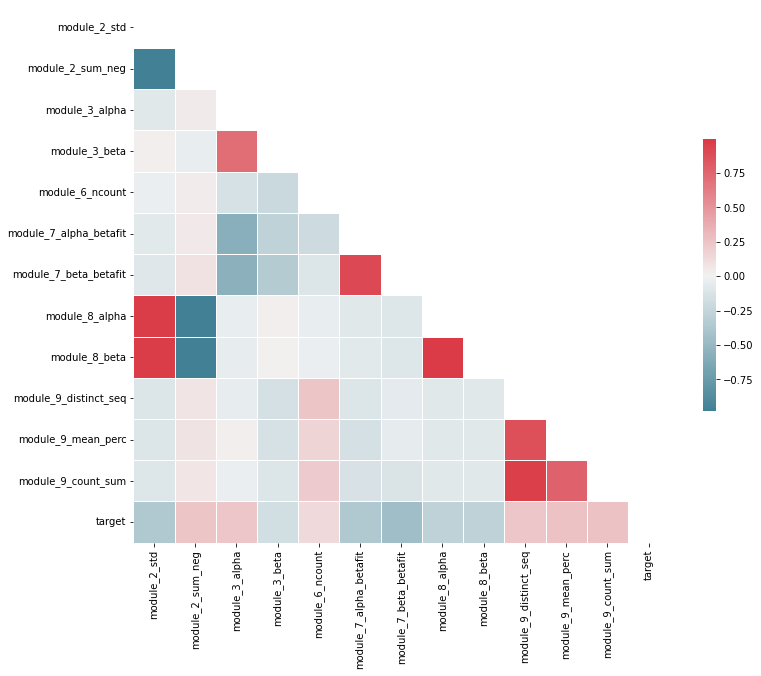

In [12]:
train = X_train.copy()
train.loc[:, 'target'] = y_train.tolist()
train

corr_matrix = train.corr()

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))
cmap = sn.diverging_palette(220, 10, as_cmap=True)
sn.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5})

#### Support Vector Machine Training

In [13]:
clf_svc = svm.SVC(kernel='linear')

In [14]:
clf_svc.fit(X_train, y_train)

SVC(kernel='linear')

##### SVM performance

In [15]:
y_pred=clf_svc.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("F1 Score: ", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8518518518518519
Precision:  0.8095238095238095
Recall:  1.0
F1 Score:  0.8947368421052632


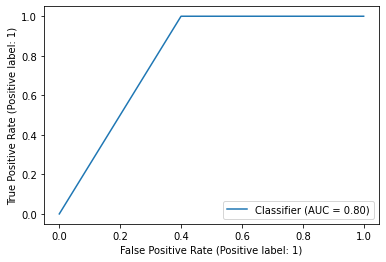

In [16]:
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)

#### SVM with Cross Validation

In [17]:
clf_svm_cv = svm.SVC(kernel='linear')
scores = cross_validate(clf_svm_cv, ngs_reads, target, cv=5, 
                        scoring=('accuracy', 'f1'), return_train_score=True)
print("Accuracies: ", scores['test_accuracy'])
print("F1 Scores: ", scores['test_f1'])

print("Accuracy: %0.2f +/- %0.2f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1 Score: %0.2f +/- %0.2f" % (scores['test_f1'].mean(), scores['test_f1'].std()))

Accuracies:  [1.         0.83333333 0.88888889 0.88235294 0.64705882]
F1 Scores:  [1.         0.88       0.90909091 0.90909091 0.625     ]
Accuracy: 0.85 +/- 0.12
F1 Score: 0.86 +/- 0.13


#### Decision Tree

In [18]:
clf_dt = tree.DecisionTreeClassifier()
clf_dt = clf_dt.fit(X_train, y_train)

In [19]:
y_pred = clf_dt.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("F1 Score: ", metrics.f1_score(y_test, y_pred))

Accuracy: 0.9629629629629629
Precision:  1.0
Recall:  0.9411764705882353
F1 Score:  0.9696969696969697


[Text(0.5, 0.875, 'module_2_std <= 0.152\ngini = 0.477\nsamples = 61\nvalue = [24, 37]\nclass = good'),
 Text(0.25, 0.625, 'module_7_beta_betafit <= 1.013\ngini = 0.059\nsamples = 33\nvalue = [1, 32]\nclass = good'),
 Text(0.125, 0.375, 'gini = 0.0\nsamples = 32\nvalue = [0, 32]\nclass = good'),
 Text(0.375, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = ugly'),
 Text(0.75, 0.625, 'module_7_alpha_betafit <= 1.268\ngini = 0.293\nsamples = 28\nvalue = [23, 5]\nclass = ugly'),
 Text(0.625, 0.375, 'module_7_alpha_betafit <= 1.003\ngini = 0.408\nsamples = 7\nvalue = [2, 5]\nclass = good'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = ugly'),
 Text(0.75, 0.125, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]\nclass = good'),
 Text(0.875, 0.375, 'gini = 0.0\nsamples = 21\nvalue = [21, 0]\nclass = ugly')]

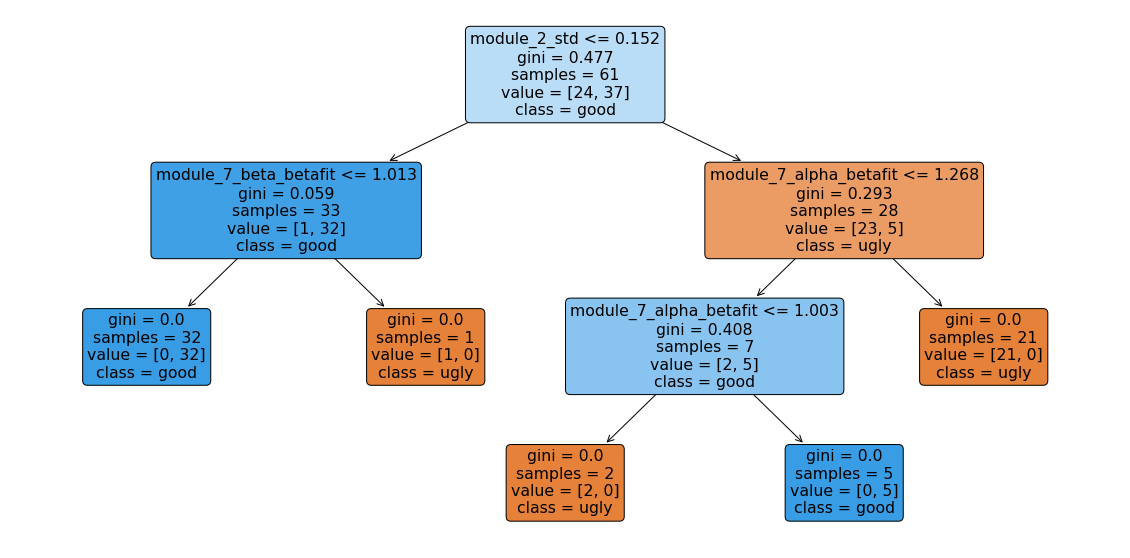

In [20]:
fig = plt.figure(figsize=(20, 10))
tree.plot_tree(clf_dt, 
          feature_names=ngs_reads.columns,
          class_names=['ugly', 'good'], 
          filled=True, impurity=True, 
          rounded=True)

#### Random Forest Training

In [21]:
clf_rf=RandomForestClassifier(n_estimators=100, verbose=True)

In [22]:
clf_rf.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(verbose=True)

##### Random Forest performance

In [23]:
y_pred = clf_rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("F1 Score: ", metrics.f1_score(y_test, y_pred))

Accuracy: 1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


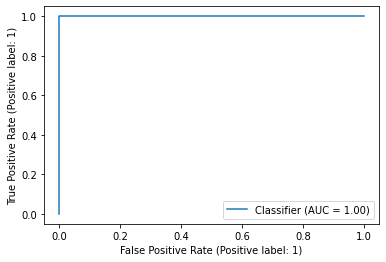

In [24]:
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)

#### Feature Importance Random Forest

Text(0.5, 0, 'Relative Importance')

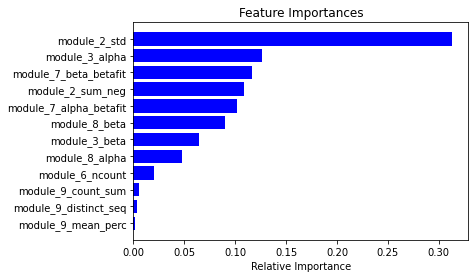

In [25]:
importances = clf_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel('Relative Importance')

#### Random Forest with Cross Validation

In [26]:
clf_rf_cv = RandomForestClassifier(n_estimators=100)
scores = cross_validate(clf_rf_cv, ngs_reads, target, cv=5, 
                        scoring=('accuracy', 'f1'), return_train_score=True)
print("Accuracies: ", scores['test_accuracy'])
print("F1 Scores: ", scores['test_f1'])

# higher cv results in most accuracies = 1.0

print("Accuracy: %0.2f +/- %0.2f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1 Score: %0.2f +/- %0.2f" % (scores['test_f1'].mean(), scores['test_f1'].std()))

Accuracies:  [0.77777778 1.         1.         0.94117647 0.88235294]
F1 Scores:  [0.77777778 1.         1.         0.95238095 0.91666667]
Accuracy: 0.92 +/- 0.08
F1 Score: 0.93 +/- 0.08


#### Visualize some trees of the Random Forest

[Text(0.36363636363636365, 0.9166666666666666, 'module_8_beta <= 2.655\ngini = 0.497\nsamples = 35\nvalue = [33, 28]\nclass = ugly'),
 Text(0.18181818181818182, 0.75, 'module_8_alpha <= 0.878\ngini = 0.142\nsamples = 9\nvalue = [1, 12]\nclass = good'),
 Text(0.09090909090909091, 0.5833333333333334, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = ugly'),
 Text(0.2727272727272727, 0.5833333333333334, 'gini = 0.0\nsamples = 8\nvalue = [0, 12]\nclass = good'),
 Text(0.5454545454545454, 0.75, 'module_3_alpha <= 17.964\ngini = 0.444\nsamples = 26\nvalue = [32, 16]\nclass = ugly'),
 Text(0.45454545454545453, 0.5833333333333334, 'gini = 0.0\nsamples = 11\nvalue = [21, 0]\nclass = ugly'),
 Text(0.6363636363636364, 0.5833333333333334, 'module_3_beta <= 1.721\ngini = 0.483\nsamples = 15\nvalue = [11, 16]\nclass = good'),
 Text(0.45454545454545453, 0.4166666666666667, 'module_3_beta <= 1.557\ngini = 0.133\nsamples = 7\nvalue = [1, 13]\nclass = good'),
 Text(0.36363636363636365, 0.25, 'module_7_b

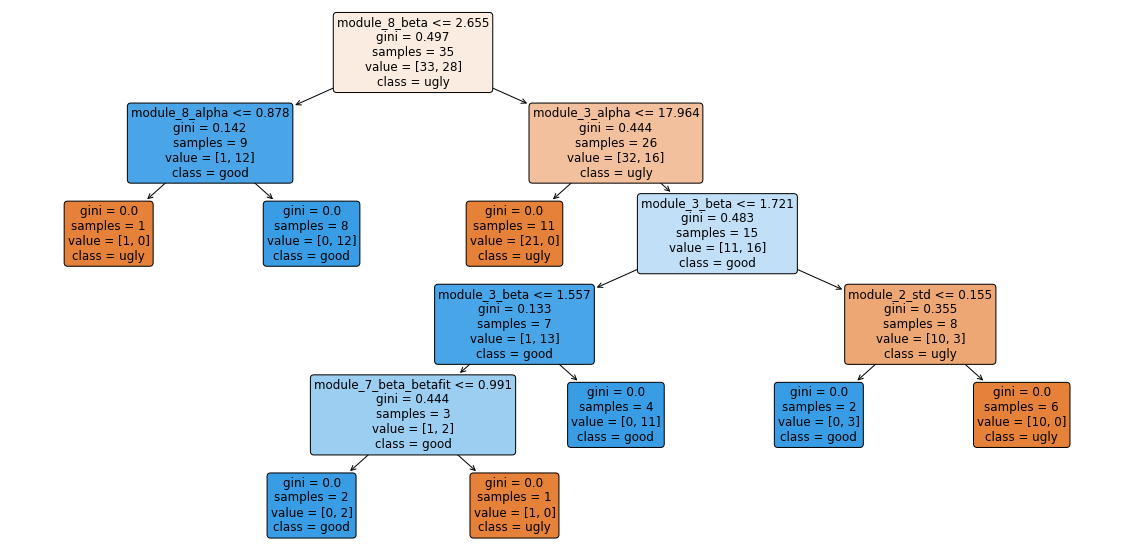

In [27]:
fig = plt.figure(figsize=(20, 10))
tree.plot_tree(clf_rf.estimators_[0], 
          feature_names=ngs_reads.columns,
          class_names=['ugly', 'good'], 
          filled=True, impurity=True, 
          rounded=True)

[Text(0.4, 0.9, 'module_3_alpha <= 16.823\ngini = 0.416\nsamples = 41\nvalue = [18, 43]\nclass = good'),
 Text(0.2, 0.7, 'gini = 0.0\nsamples = 9\nvalue = [13, 0]\nclass = ugly'),
 Text(0.6, 0.7, 'module_3_beta <= 1.927\ngini = 0.187\nsamples = 32\nvalue = [5, 43]\nclass = good'),
 Text(0.4, 0.5, 'module_3_beta <= 1.768\ngini = 0.044\nsamples = 29\nvalue = [1, 43]\nclass = good'),
 Text(0.2, 0.3, 'gini = 0.0\nsamples = 22\nvalue = [0, 34]\nclass = good'),
 Text(0.6, 0.3, 'module_6_ncount <= 0.486\ngini = 0.18\nsamples = 7\nvalue = [1, 9]\nclass = good'),
 Text(0.4, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = ugly'),
 Text(0.8, 0.1, 'gini = 0.0\nsamples = 6\nvalue = [0, 9]\nclass = good'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 3\nvalue = [4, 0]\nclass = ugly')]

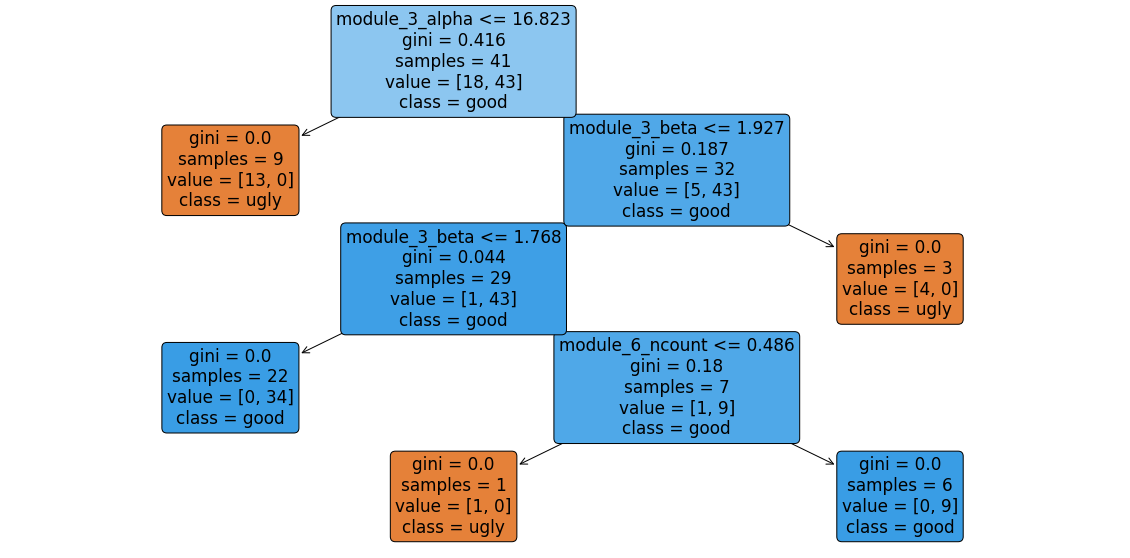

In [28]:
fig = plt.figure(figsize=(20, 10))
tree.plot_tree(clf_rf.estimators_[12], 
          feature_names=ngs_reads.columns,
          class_names=['ugly', 'good'], 
          filled=True, impurity=True, 
          rounded=True)

#### Other Classification Algorithms

Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
clf_lg = LogisticRegression(random_state=0).fit(X_train, y_train)

/home/alex/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
y_pred = clf_lg.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("F1 Score: ", metrics.f1_score(y_test, y_pred))

Accuracy: 0.7407407407407407
Precision:  0.75
Recall:  0.8823529411764706
F1 Score:  0.8108108108108107


Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB().fit(X_train, y_train)

In [32]:
y_pred = clf_gnb.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("F1 Score: ", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8518518518518519
Precision:  0.8095238095238095
Recall:  1.0
F1 Score:  0.8947368421052632


K Nearest Neighbors

In [33]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("F1 Score: ", metrics.f1_score(y_test, y_pred))

Accuracy: 0.9629629629629629
Precision:  1.0
Recall:  0.9411764705882353
F1 Score:  0.9696969696969697
